In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import numpy as np
import scanpy as sc
import pandas as pd

from micron2.spatial import (get_neighbors, categorical_neighbors, 
                             sliding_window_niches, k_neighbor_niches,
                             celltype_distances
                            )

rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['svg.fonttype'] = 'none'

In [3]:
adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged_v10.h5ad")
adata

AnnData object with n_obs × n_vars = 598327 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating', 'subtype_gates', 'subtype_gating', 'subtype_rescued', 'subtype', 'celltype', 'cell_niches', 'niche_labels'
    uns: 'celltype_colors', 'channels', 'niche_labels_colors', 'niche_profiles_colnames', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors', 'subtype_colors', 'subtype_gating_colors'
    obsm: 'coordinates', 'coordinates_shift', 'niche_profiles'

In [4]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

# Marker enrichment amongst celltypes 

In [14]:
from scipy.stats import mannwhitneyu, wilcoxon
import itertools

In [15]:
adata

AnnData object with n_obs × n_vars = 598327 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating', 'subtype_gates', 'subtype_gating', 'subtype_rescued', 'subtype', 'celltype', 'cell_niches', 'niche_labels'
    uns: 'celltype_colors', 'channels', 'niche_labels_colors', 'niche_profiles_colnames', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors', 'subtype_colors', 'subtype_gating_colors'
    obsm: 'coordinates', 'coordinates_shift', 'niche_profiles'

In [16]:
subtypes = np.unique(adata.obs.subtype)
features = [f for f in adata.uns['channels'] if f!='DAPI']

enrich = pd.DataFrame(index=subtypes, columns=features, dtype=np.float32)
pvals = pd.DataFrame(index=subtypes, columns=features, dtype=np.float32)
for f in features:
    #fvals = np.log10(adata[:, f'{f}_membrane_mean'].X.toarray().flatten())
    fvals = adata[:, f'{f}_membrane_mean'].X.toarray().flatten()
    
    for s in subtypes:
        svals = fvals[adata.obs.niche_labels == s]
        ovals = fvals[adata.obs.niche_labels != s]
        ovals = np.random.choice(ovals, len(svals), replace=False)

        smean = np.mean(svals)
        omean = np.mean(ovals)
        #fc = (smean - omean)/omean
        fc = smean / omean
        res = wilcoxon(svals, ovals)

        enrich.loc[s,f] = np.log10(fc)
        pvals.loc[s,f] = res[1]


<AxesSubplot:>

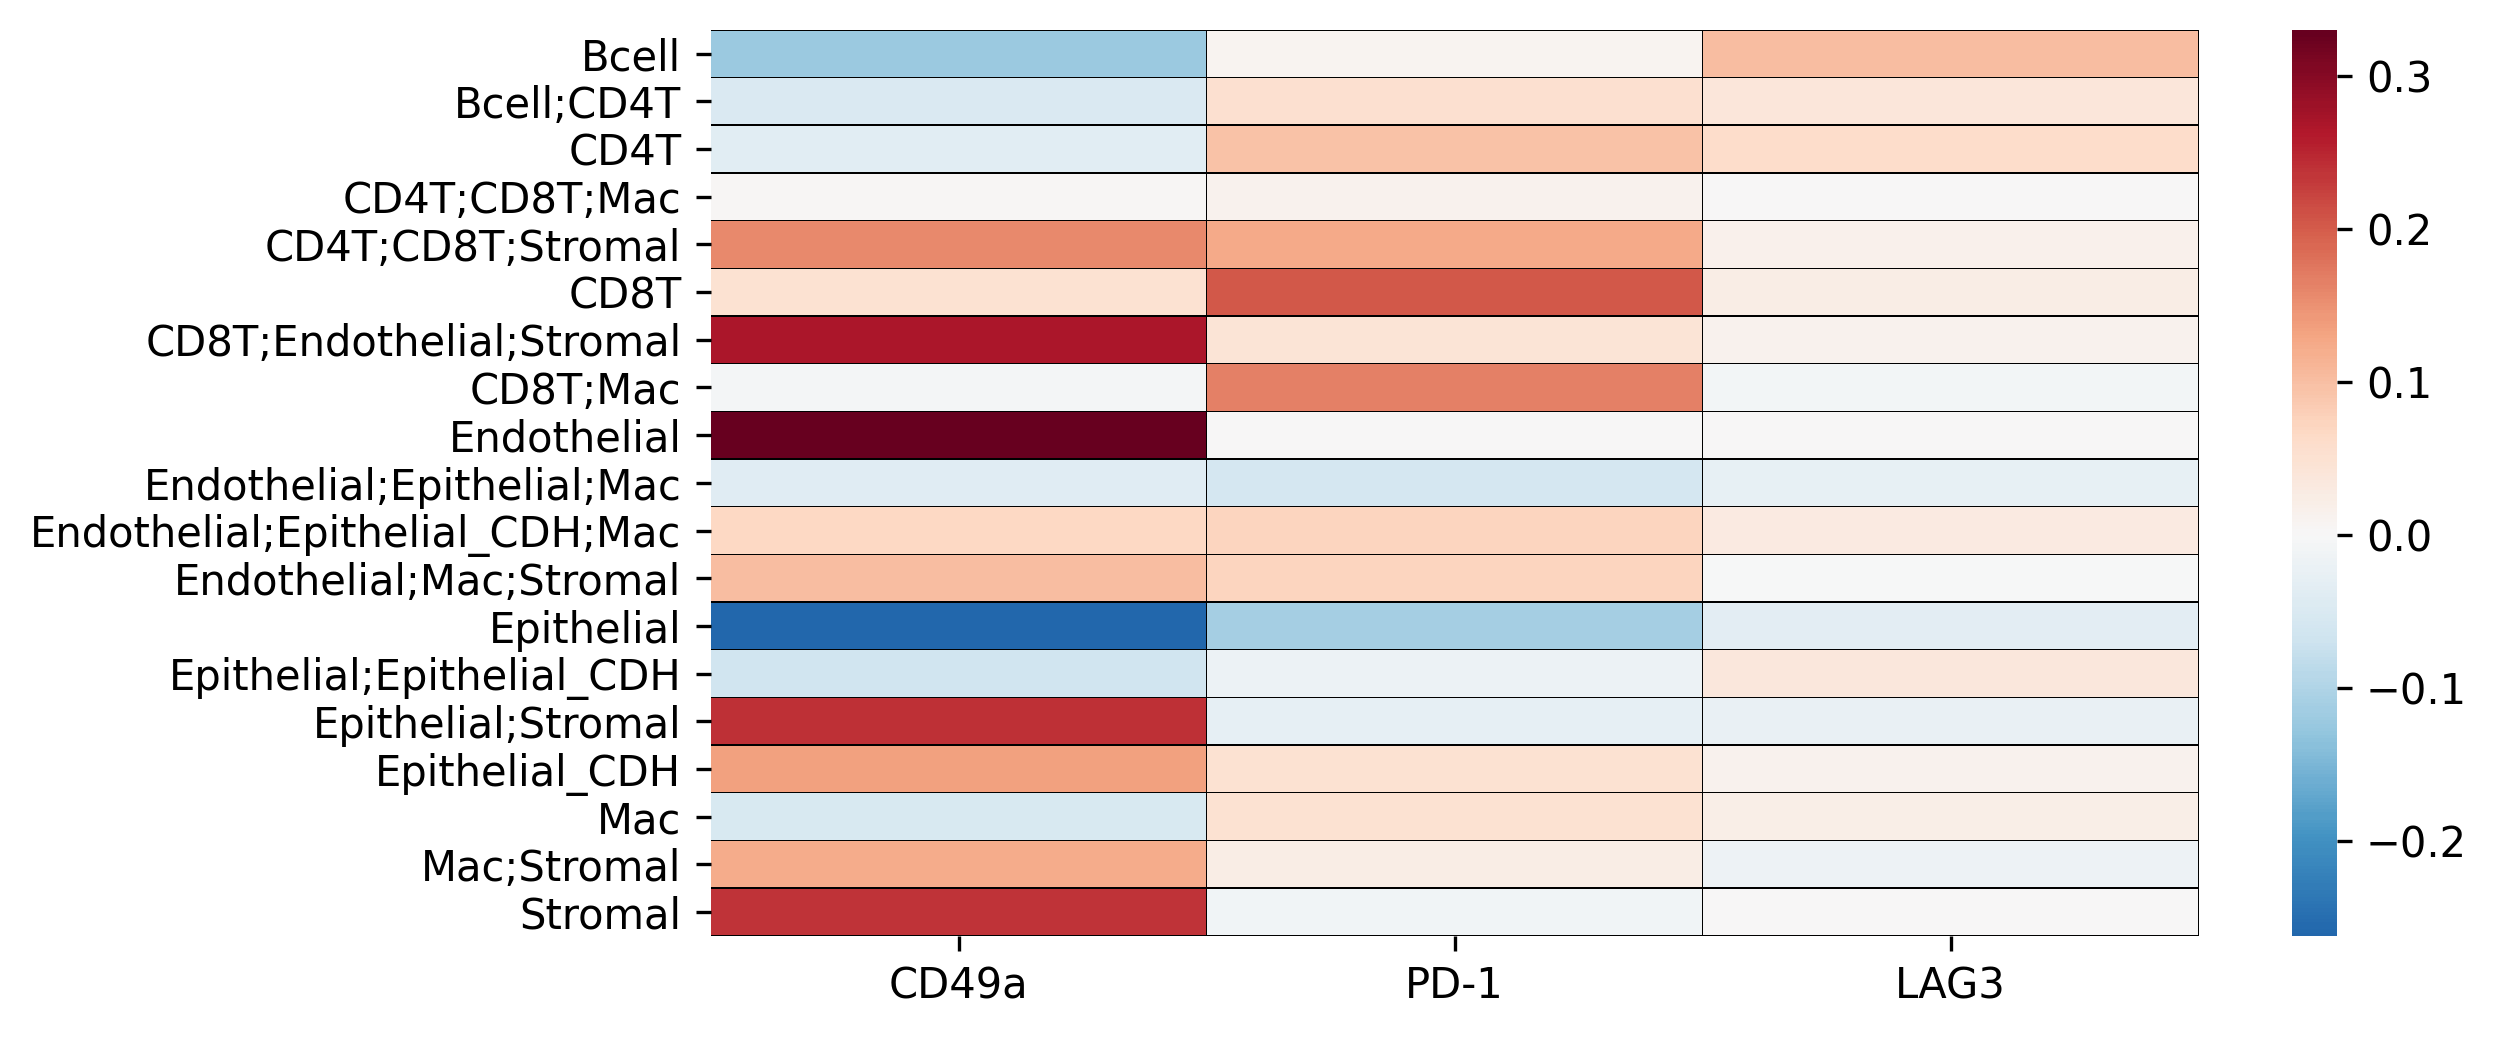

In [18]:
subtypes_order = [
    'Epithelial', 'Epithelial_CDH', 'Epithelial_KRT13', 'Epithelial_KRT17', 'Endothelial',
    'Stromal', 'Mac', 'CD8T_Trm', 'CD8T', 'CD8T_exhausted', 'CD8T_activated', 'Bcell',
    'CD4T', 'CD4T_Treg'
]
features_order = [
    'CDH1', 'ERBB2', 'CD11c', 'PD-L2', 'CK5-6', 'KRT20', 'PanCytoK', 'CDH12', 'KRT13', 'KRT17',
    'GATA3', 'Ki-67', 'aSMA', 'CD49a', 'CD31', 'CD68', 'GZMB', 'CD103', 'CDH18', 'PD-1', 'CD8', 'PDGFRb',
    'UPK3', 'PD-L1', 'CD69', 'LAG3', 'CD20', 'CD45RA', 'CD45', 'CD4', 'CD3e', 'CD45RO', 
    'CD44', 'HLA-DR', 'FOXP3'
]

enrich = enrich.loc[subtypes_order, features_order]

plt.figure(figsize=(8,4), dpi=300)
ax = plt.gca()
sns.heatmap(enrich, cmap='RdBu_r', center=0, #vmin=-1, vmax=1,
            lw=0.1, linecolor='k', xticklabels=True, ax=ax)

In [319]:
pvals_np = np.array(pvals.values)
pvals_np[pvals_np == 0] = np.min(pvals_np[pvals_np > 0])

In [320]:
pvals_np = np.array(pvals.values)
pvals_np[pvals_np == 0] = np.min(pvals_np[pvals_np > 0])
pvals_np = pd.DataFrame(-np.log10(pvals_np), index=pvals.index, columns=pvals.columns)

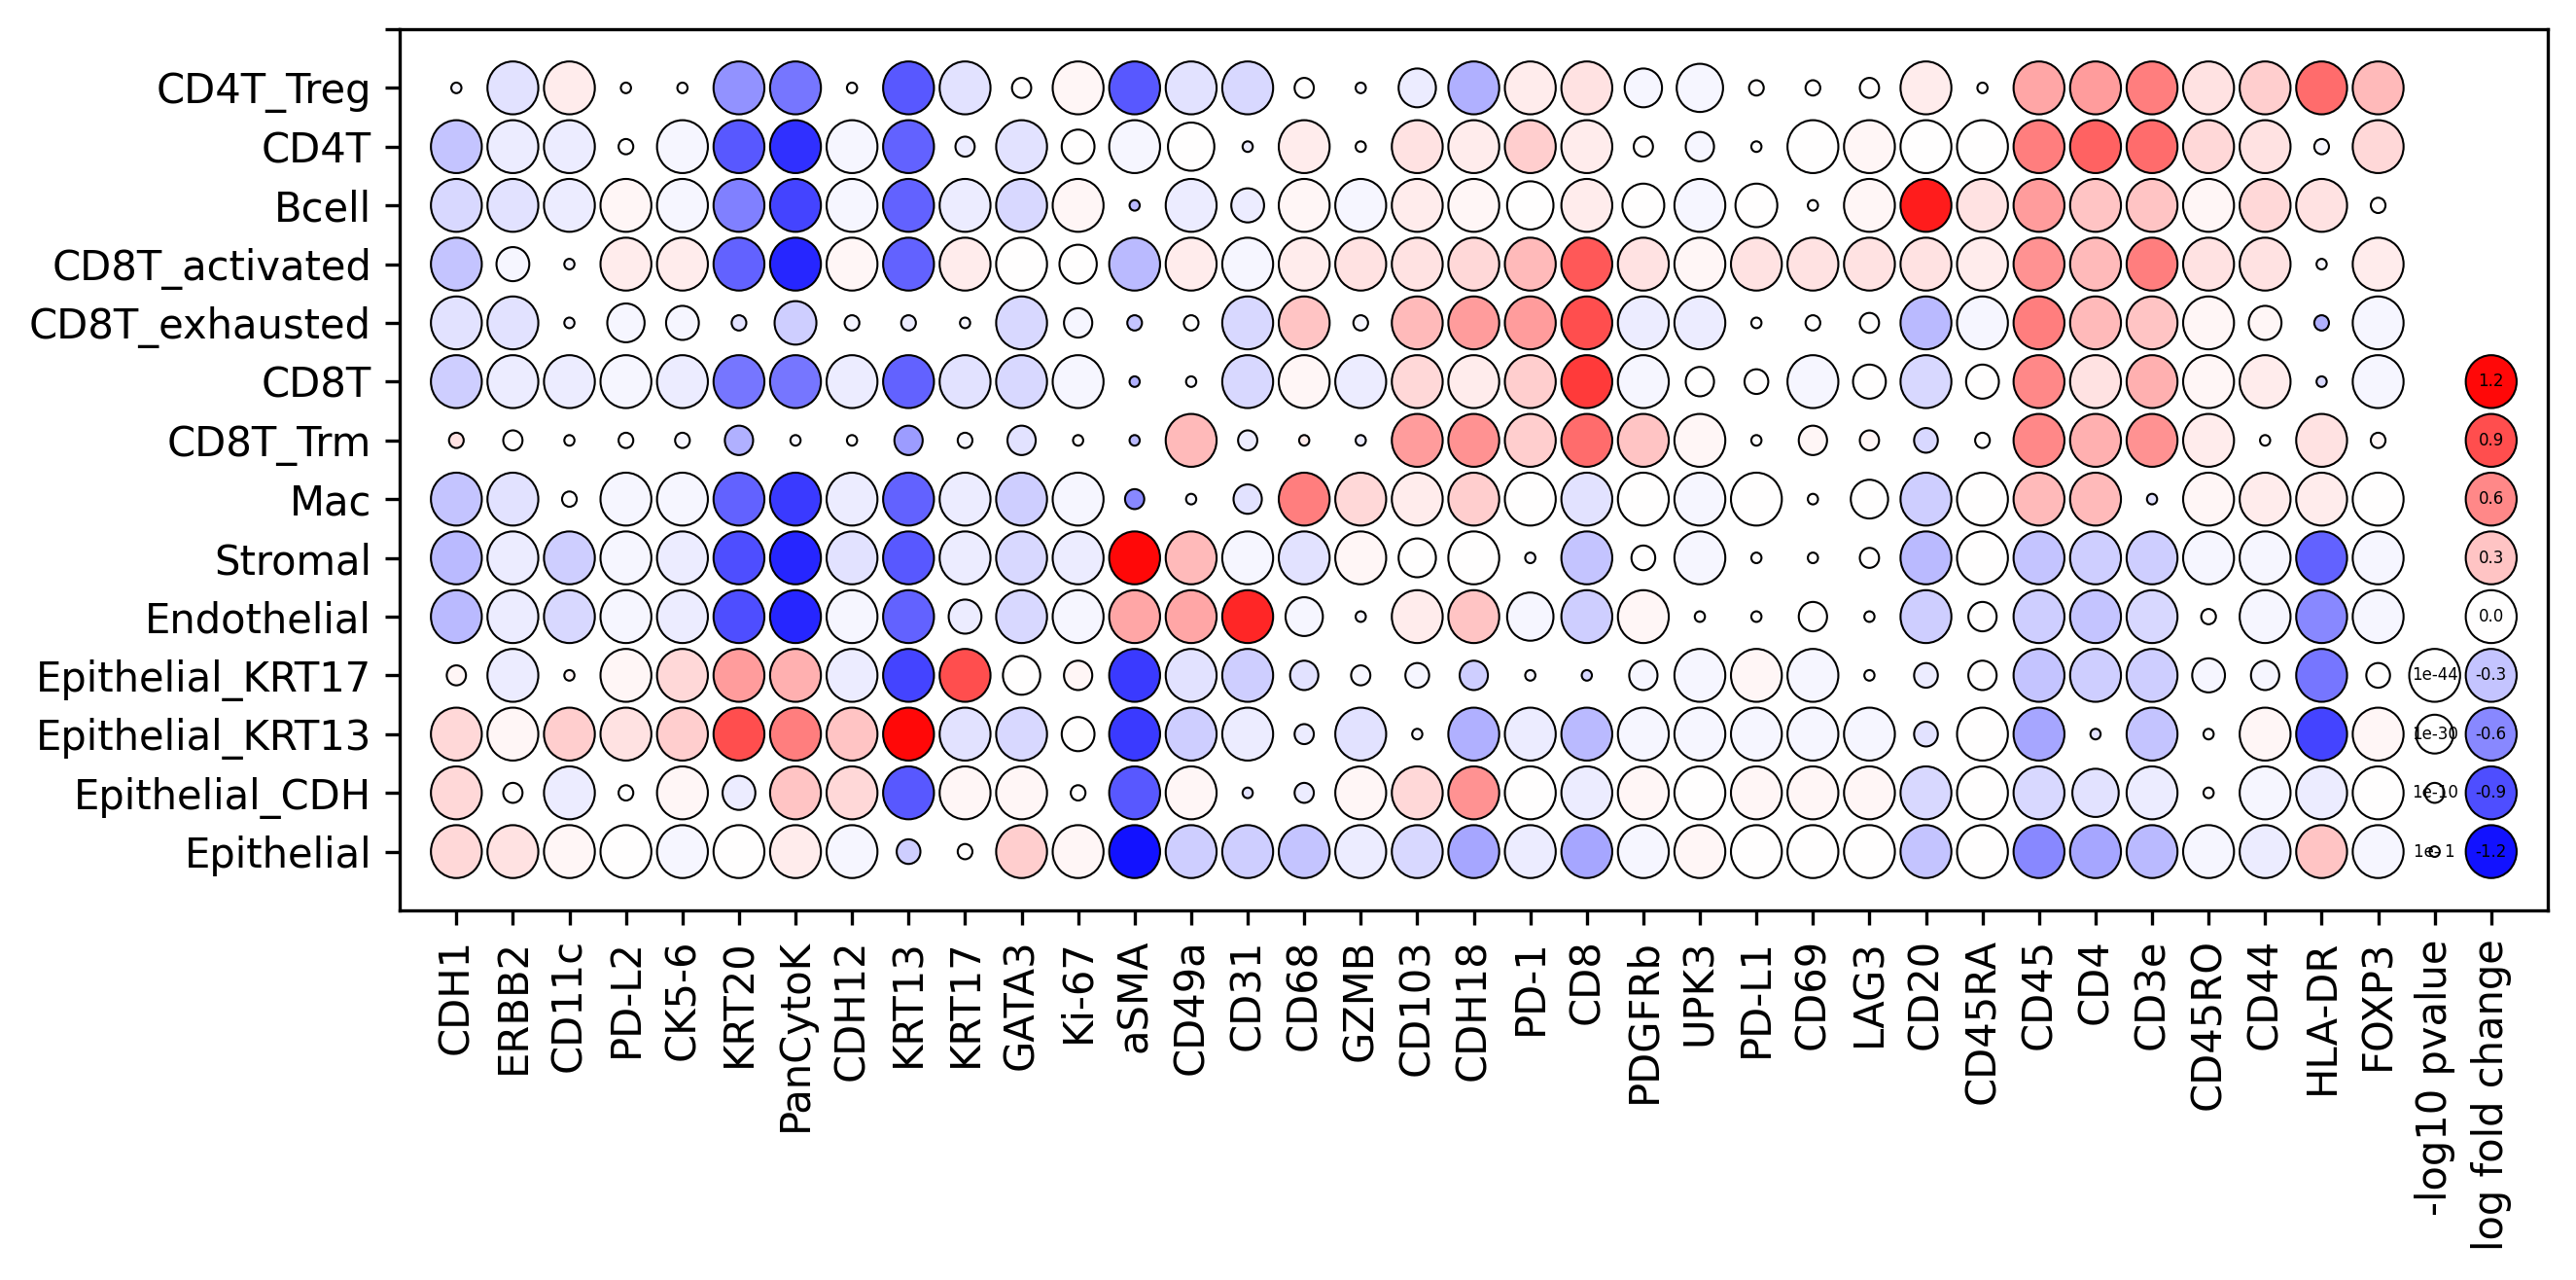

In [341]:
from matplotlib.patches import Circle
rcParams['svg.fonttype'] = 'none'
rcParams['figure.facecolor'] = (1,1,1,1)

# pvals_np = pd.DataFrame(-np.log10(pvals_np), index=pvals.index, columns=pvals.columns)
pvals_np = pvals_np.loc[subtypes_order, features_order]

max_size = 0.45
min_size = 0.05
size_scale = np.linspace(min_size, max_size, 11)
size_bins = np.linspace(0, np.max(pvals_np.values), 10)

min_enrich = -1.2
max_enrich = 1.2
cmap = np.array(sns.color_palette('bwr', 51))
enrich_bins = np.linspace(min_enrich, max_enrich, 50)

plt.figure(figsize=(9.5,4), dpi=300)
ax = plt.gca()

for i,s in enumerate(subtypes_order):
    for j,f in enumerate(features_order):
        p = np.digitize(pvals_np.loc[s,f], size_bins)
        e = np.digitize(enrich.loc[s,f], enrich_bins)
        c = Circle((j,i), radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
        ax.add_artist(c)
        
# legends
for i,v in zip(range(4), [1, 10, 30, size_bins[-1]]):
    p = np.digitize(v, size_bins)
    coord = (len(features_order), i)
    c = Circle(coord, radius=size_scale[p], color='w', lw=0.5, ec='k')
    ax.add_artist(c)
    ax.annotate(f'1e-{v:2.0f}', coord, fontsize=4, ha='center', va='center')
    
p = np.digitize(size_bins[-1], size_bins)
for i,v in zip(range(9), np.linspace(min_enrich, max_enrich, 9)):
    e = np.digitize(v, enrich_bins)
    coord = (len(features_order)+1, i)
    c = Circle(coord, radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
    ax.annotate(f'{v:1.1f}', coord, fontsize=4, ha='center', va='center')
    ax.add_artist(c)
        
ax.set_xlim([-1,len(features_order)+2])
ax.set_ylim([-1,len(subtypes_order)])
_ = ax.set_xticks(range(len(features_order)+2))
_ = ax.set_yticks(range(len(subtypes_order)+1))
_ = ax.set_xticklabels(features_order+['-log10 pvalue', 'log fold change'],rotation=90)
_ = ax.set_yticklabels(subtypes_order+[''],rotation=0)


plt.savefig(f'figures/marker_expression.svg', bbox_inches='tight', transparent=True)

# Marker by niche

In [5]:
from scipy.stats import mannwhitneyu, wilcoxon
import itertools

In [15]:
adata

AnnData object with n_obs × n_vars = 598327 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating', 'subtype_gates', 'subtype_gating', 'subtype_rescued', 'subtype', 'celltype', 'cell_niches', 'niche_labels'
    uns: 'celltype_colors', 'channels', 'niche_labels_colors', 'niche_profiles_colnames', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors', 'subtype_colors', 'subtype_gating_colors'
    obsm: 'coordinates', 'coordinates_shift', 'niche_profiles'

In [87]:
subtype_2 = np.array(adata.obs.subtype)
subtype_2[subtype_2 == 'Epithelial_KRT13'] = 'Epithelial_KRT13_KRT17'
subtype_2[subtype_2 == 'Epithelial_KRT17'] = 'Epithelial_KRT13_KRT17'
adata.obs['subtype_2'] = pd.Categorical(subtype_2)

cellgroups = np.unique(adata.obs.niche_labels)
features = [f for f in adata.uns['channels'] if f!='DAPI']

celltypes = adata.obs.celltype
in_target = 'Epithelial_CDH'
out_target = 'Epithelial'

# stationary reference niche
ref_niche = 'Epithelial'

enrich = pd.DataFrame(index=cellgroups, columns=features, dtype=np.float32)
pvals = pd.DataFrame(index=cellgroups, columns=features, dtype=np.float32)

np.random.seed(999)
for f in features:
    #fvals = np.log10(adata[:, f'{f}_membrane_mean'].X.toarray().flatten())
    fvals = adata[:, f'{f}_membrane_mean'].X.toarray().flatten()
    
    for s in cellgroups:
        sidx = (adata.obs.niche_labels == s) & (celltypes == in_target)
        #oidx = (adata.obs.niche_labels != s) & (celltypes == out_target)
        ## stationary reference niche
        oidx = (adata.obs.niche_labels == ref_niche) & (celltypes == out_target)
        
        if (np.sum(sidx)==0) or (np.sum(oidx)==0):
            enrich.loc[s,f] = 0
            pvals.loc[s,f] = 1
            continue
        
        svals = fvals[sidx]
        ovals = fvals[oidx]
        ovals = np.random.choice(ovals, len(svals), replace=False)

        smean = np.mean(svals)
        omean = np.mean(ovals)
        #fc = (smean - omean)/omean
        fc = smean / omean
        res = wilcoxon(svals, ovals)

        enrich.loc[s,f] = np.log2(fc)
        pvals.loc[s,f] = res[1]


<AxesSubplot:>

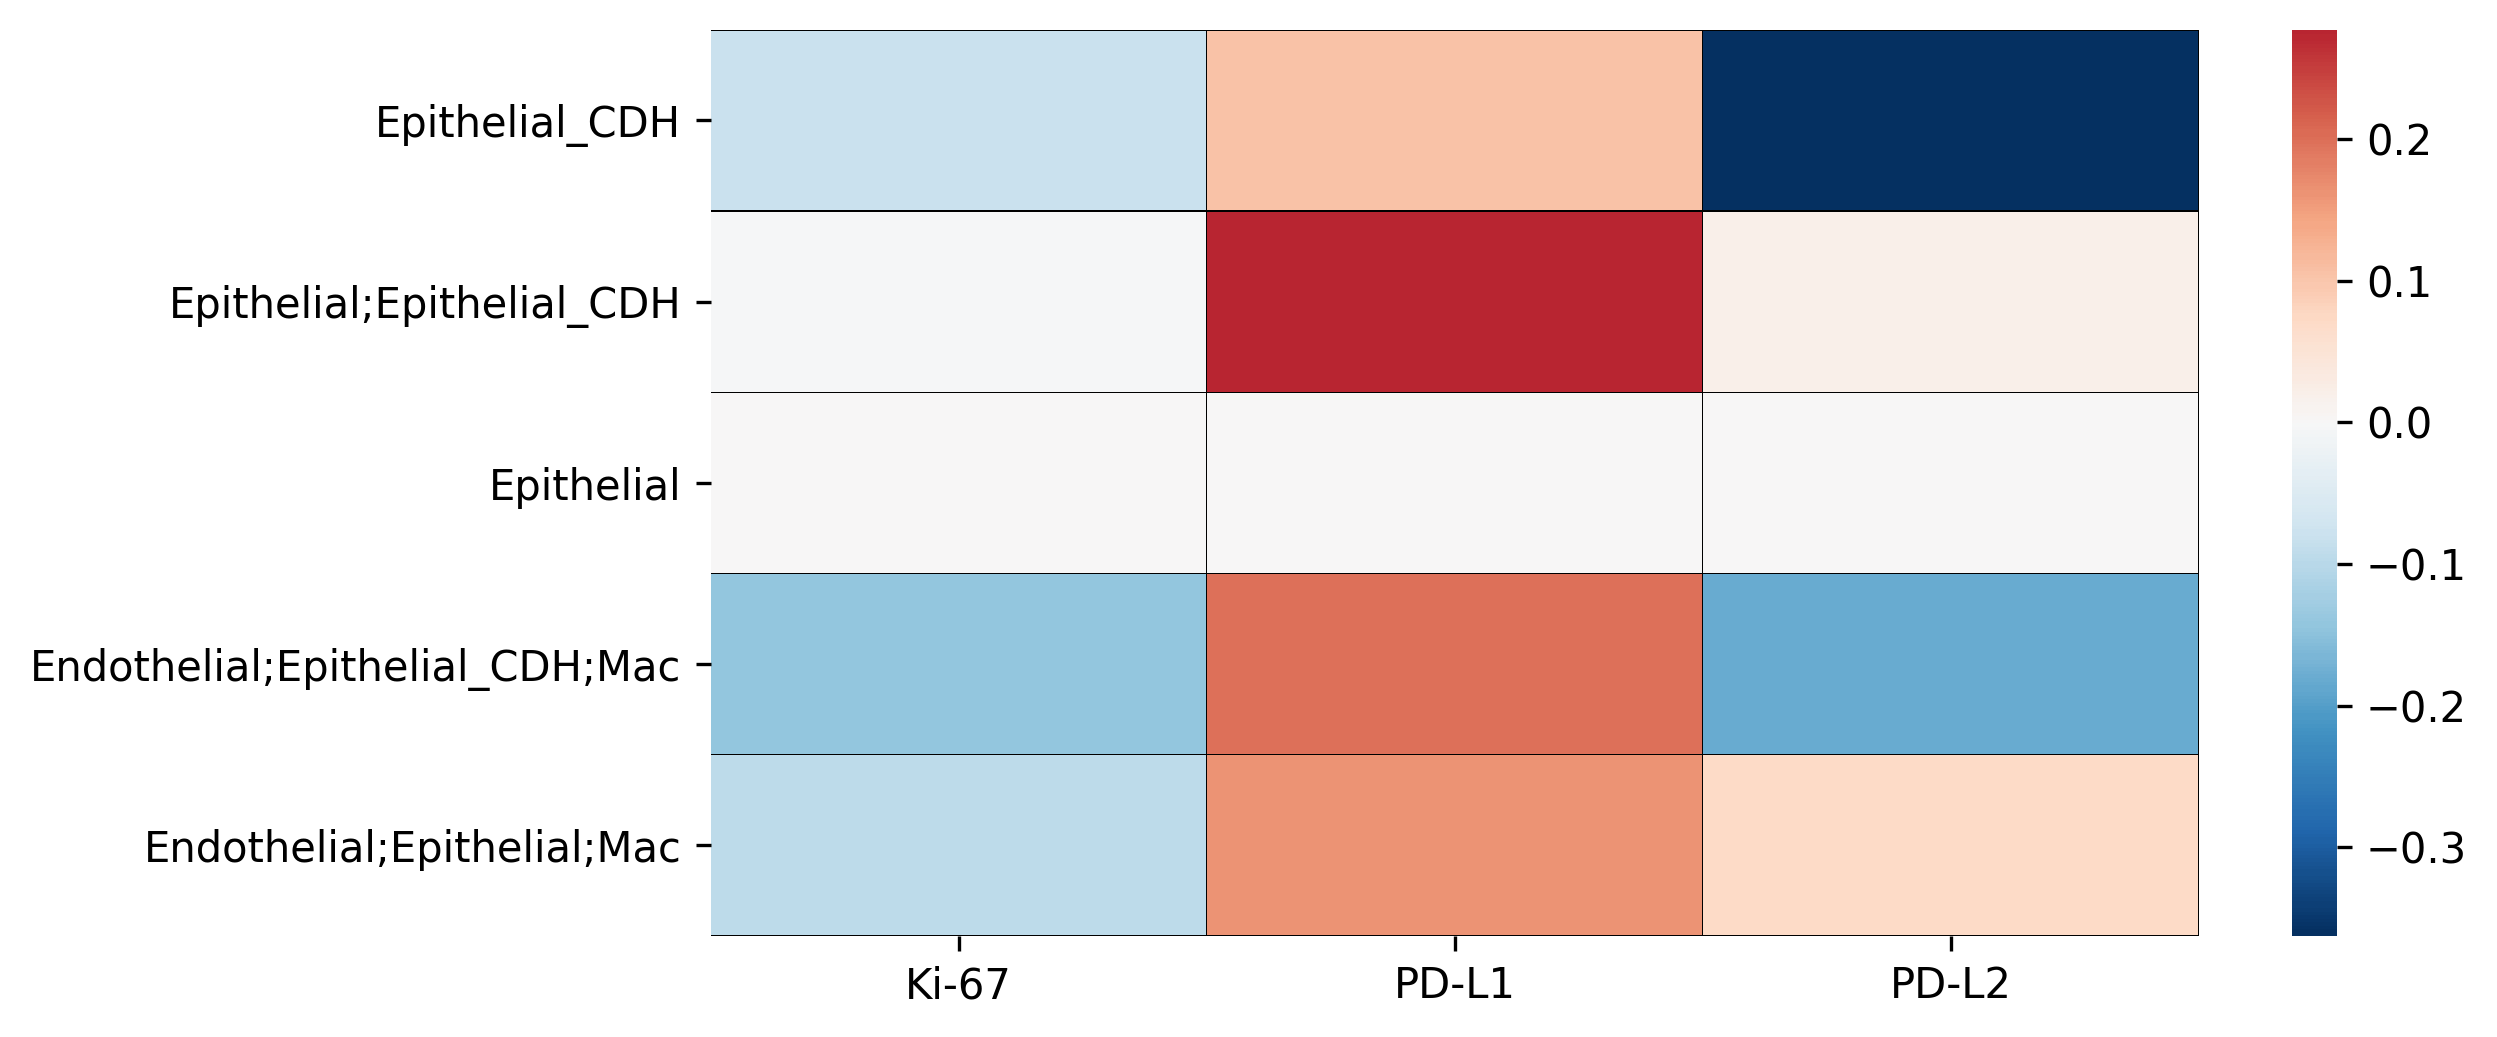

In [88]:
subtypes_order = [
    'Epithelial', 'Epithelial_CDH', 'Epithelial_KRT13', 'Epithelial_KRT17', 'Endothelial',
    'Stromal', 'Mac', 'CD8T_Trm', 'CD8T', 'CD8T_exhausted', 'CD8T_activated', 'Bcell',
    'CD4T', 'CD4T_Treg'
]
features_order = [
    'CDH1', 'ERBB2', 'CD11c', 'PD-L2', 'CK5-6', 'KRT20', 'PanCytoK', 'CDH12', 'KRT13', 'KRT17',
    'GATA3', 'Ki-67', 'aSMA', 'CD49a', 'CD31', 'CD68', 'GZMB', 'CD103', 'CDH18', 'PD-1', 'CD8', 'PDGFRb',
    'UPK3', 'PD-L1', 'CD69', 'LAG3', 'CD20', 'CD45RA', 'CD45', 'CD4', 'CD3e', 'CD45RO', 
    'CD44', 'HLA-DR', 'FOXP3'
]
niche_order = [
#     'Epithelial;Stromal',
    'Epithelial_CDH',
    'Epithelial;Epithelial_CDH',
    'Epithelial',
    'Endothelial;Epithelial_CDH;Mac',
    'Endothelial;Epithelial;Mac'
]

# enrich = enrich.loc[subtypes_order, features_order]
# enrich_ = enrich.loc[niche_order, ['CD49a', 'PD-1', 'LAG3']]
enrich_ = enrich.loc[niche_order, ['Ki-67', 'PD-L1', 'PD-L2']]

plt.figure(figsize=(8,4), dpi=300)
ax = plt.gca()
sns.heatmap(enrich_, cmap='RdBu_r', center=0, #vmin=-1, vmax=1,
            lw=0.1, linecolor='k', xticklabels=True, ax=ax)

In [92]:
pvals_np = np.array(pvals.values)
pvals_np[pvals_np == 0] = np.min(pvals_np[pvals_np > 0])
pvals_np = pd.DataFrame(-np.log10(pvals_np), index=pvals.index, columns=pvals.columns)

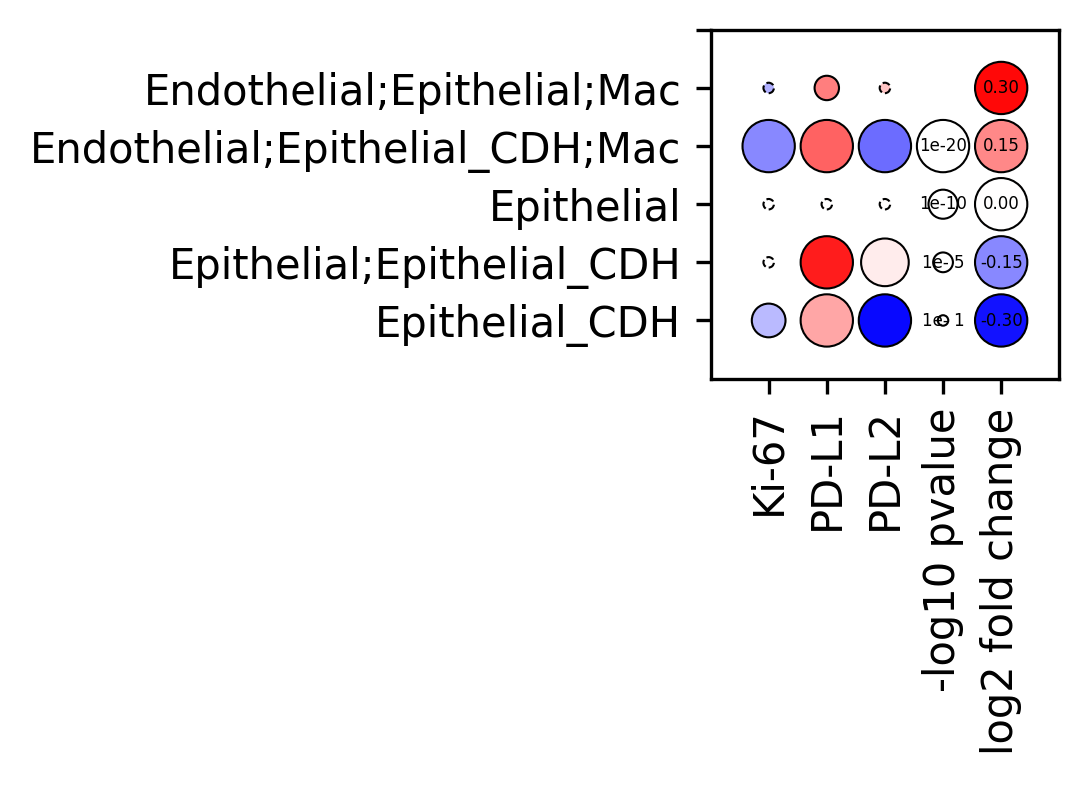

In [93]:
from matplotlib.patches import Circle
rcParams['svg.fonttype'] = 'none'
rcParams['figure.facecolor'] = (1,1,1,1)

# pvals_np = pd.DataFrame(-np.log10(pvals_np), index=pvals.index, columns=pvals.columns)
pvals_np_ = pvals_np.loc[enrich_.index, enrich_.columns]

max_size = 0.45
min_size = 0.05
size_scale = np.linspace(min_size, max_size, 11)
# size_bins = np.linspace(0, np.max(pvals_np_.values), 10)
size_bins = np.linspace(0, 20, 10)

min_enrich = -0.3
max_enrich = 0.3
cmap = np.array(sns.color_palette('bwr', 51))
enrich_bins = np.linspace(min_enrich, max_enrich, 50)

plt.figure(figsize=(1.5,1.75), dpi=300)
ax = plt.gca()

sig = 0.05

for i,s in enumerate(enrich_.index):
    for j,f in enumerate(enrich_.columns):
        p = np.digitize(pvals_np_.loc[s,f], size_bins)
        e = np.digitize(enrich_.loc[s,f], enrich_bins)
        #c = Circle((j,i), radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
        if pvals.loc[s,f] > sig:
            c = Circle((j,i), radius=size_scale[p], color=cmap[e], lw=0.5, ec='k', ls='--')
        else:
            c = Circle((j,i), radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
            
        ax.add_artist(c)
        
# legends
for i,v in zip(range(4), [1, 5, 10, size_bins[-1]]):
    p = np.digitize(v, size_bins)
    coord = (len(enrich_.columns), i)
    c = Circle(coord, radius=size_scale[p], color='w', lw=0.5, ec='k')
    ax.add_artist(c)
    ax.annotate(f'1e-{v:2.0f}', coord, fontsize=4, ha='center', va='center')
    
p = np.digitize(size_bins[-1], size_bins)
for i,v in zip(range(5), np.linspace(min_enrich, max_enrich, 5)):
    e = np.digitize(v, enrich_bins)
    coord = (len(enrich_.columns)+1, i)
    c = Circle(coord, radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
    ax.annotate(f'{v:1.2f}', coord, fontsize=4, ha='center', va='center')
    ax.add_artist(c)
        
ax.set_xlim([-1,len(enrich_.columns)+2])
ax.set_ylim([-1,len(enrich_.index)])
_ = ax.set_xticks(range(len(enrich_.columns)+2))
_ = ax.set_yticks(range(len(enrich_.index)+1))
_ = ax.set_xticklabels(enrich_.columns.tolist()+['-log10 pvalue', 'log2 fold change'],rotation=90)
_ = ax.set_yticklabels(enrich_.index.tolist()+[''],rotation=0)
ax.set_aspect('equal')

# plt.savefig(f'figures/CDH12_vs_CDH12_marker_expression_niches_sig.svg', bbox_inches='tight', transparent=True)
# plt.savefig(f'figures/CDH12_vs_OtherEpithelial_marker_expression_niches_sig.svg', bbox_inches='tight', transparent=True)
# plt.savefig(f'figures/CD8T_vs_CD8T_marker_expression_niches_sig.svg', bbox_inches='tight', transparent=True)

In [ ]:
# Random: check broad cell breakdown